In [28]:
import cmocean as cmo
import gc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os

In [29]:
# Load predictions
fnam = "/home/jbassham/jack/thesis-rough/data/sh/outputs/cnn/weighted/CNNPreds_sh_1992_2020.npz"
data = np.load(fnam, allow_pickle = True)

upred = data['y_pred'][:,0,:,:]
vpred = data['y_pred'][:,1,:,:]

utrue = data['y_true'][:,0,:,:]
vtrue = data['y_true'][:,1,:,:]

In [30]:
# Delete unused variables from memory
del data
gc.collect()

1179

In [31]:
# load latitude longitude grid for plotting
fnam = "/home/jbassham/jack/thesis-rough/data/sh/inputs/lat_lon_sh_1992_2020.npz"
data = np.load(fnam, allow_pickle = True)

lat = data['lat']
lon = data['lon']

In [32]:
# Load CNN data split indices and land mask
fnam = "/home/jbassham/jack/thesis-rough/data/sh/cnn-inputs/indices_land_sh_1992_2020.npz"
data = np.load(fnam, allow_pickle = True)

train_idx = data['train_idx']
val_idx = data['val_idx']
test_idx = data['test_idx']
land_mask = data['land_mask']

In [33]:
# Load uncertainty, ice velocities
fnam = "/home/jbassham/jack/thesis-rough/data/sh/inputs/inputs_normalized_sh_1992_2020.npz"
data = np.load(fnam, allow_pickle=True)
rt = data['rtn']
uit = data['uitn']
vit = data['vitn']

In [34]:
# Load time variable
fnam = "/home/jbassham/jack/thesis-rough/data/sh/inputs/time_today_sh_1992_2020.npz"
data = np.load(fnam, allow_pickle = True)

time = data['time_today']


In [35]:
# Crop uncertainty, ice velocities to test indices
rtest = rt[test_idx,:,:]
uitest = uit[test_idx,:,:] 
vitest = vit[test_idx,:,:]

timetest = time[test_idx]

In [36]:
# Delete unused variables from memory
del time, data, rt, uit, vit
gc.collect()

110

In [37]:
def correlation(pred, true):

    """
    Pearson Correlation
    """

    predbar = np.nanmean(pred, axis = 0) # mean predicted
    truebar = np.nanmean(true, axis = 0) # mean true

    covariance = np.nansum((pred - predbar) * (true - truebar), axis = 0) # covariance between predicted and true
    
    stdpred = np.sqrt(np.nansum((pred - predbar)**2, axis = 0)) # standard deviation predited
    stdtrue = np.sqrt(np.nansum((true - truebar)**2, axis = 0)) # standard deviation true

    correlation = covariance / (stdpred * stdtrue)

    return correlation

In [38]:
def weighted_correlation(pred, true, r, epsilon = 1e-4):

    """
    Weighted Pearson Correlation referenced from:
    https://www.air.org/sites/default/files/2021-06/Weighted-and-Unweighted-Correlation-Methods-Large-Scale-Educational-Assessment-April-2018.pdf
    
    """

    w = 1 / (r + epsilon)

    def weighted_mean(x, w):
        return np.nansum(w * x, axis = 0) / np.nansum(w, axis = 0)

    predbar = weighted_mean(pred, w) # weighted mean predicted
    truebar = weighted_mean(true, w) # weighted mean true

    weighted_cov = np.nansum(w * (pred - predbar) * (true - truebar), axis = 0) # weighted covariance between predicted and true
    
    weighted_stdpred = np.sqrt(np.nansum(w * (pred - predbar)**2, axis = 0)) # weighted standard deviation predited
    weighted_stdtrue = np.sqrt(np.nansum(w * (true - truebar)**2, axis = 0)) # weighted standard deviation true

    correlation = weighted_cov / (weighted_stdpred * weighted_stdtrue)

    return correlation

In [39]:
def skill(pred, true, epsilon = 1e-4):
    # NOTE excluding epsilon = 1e-4 from denominator for now

    mse = np.nanmean((true - pred)**2, axis = 0) # mean square error
    # NOTE above is not equivalent to np.nanvar(true-pred), which excludes bias term
    # MSE = E[(y-x)^2]
    # = (E[y-x])^2 + Var(y-x)
    # = bias^2 + Var(y-x)
    # Can prove the above

    truebar = np.nanmean(true, axis = 0) # mean true

    vartrue = np.nanmean((true - truebar)**2, axis = 0) # variance in true
    # NOTE above is equivalent to np.nanvar()

    skill = 1 - mse / vartrue

    return skill

In [40]:
def weighted_skill(pred, true, r, epsilon = 1e-4):
    # NOTE excluding epsilon = 1e-4 from denominator for now
    # NOTE including epsilon = 1e-4 in the weights in case of uncertainty r ~ 0

    w = 1 / (r + epsilon)

    mse = np.nanmean(( w * (true - pred))**2, axis = 0) # mean square error
    # NOTE above is not equivalent to np.nanvar(true-pred), which excludes bias term

    truebar = np.nanmean(true, axis = 0) # mean true

    vartrue = np.nanmean(( w * (true - truebar))**2, axis = 0) # variance in true
    # NOTE above is equivalent to np.nanvar()

    weighted_skill = 1 - mse / vartrue

    return weighted_skill

In [41]:
# Get month numbers from time variable
months = (timetest.astype('datetime64[M]').astype(int) % 12) + 1

In [42]:
# print(months)

In [ ]:
# Get shape for spatial dimensions
_, ny, nx = np.shape(rtest)

# Define number of month bins
nm = 12 # number months

# Initialize arrays
uskillmonth = np.empty([nm, ny, nx])
vskillmonth = np.empty([nm, ny, nx])
uweightedskillmonth = np.empty([nm, ny, nx])
vweightedskillmonth = np.empty([nm, ny, nx])
ucorrelationmonth = np.empty([nm, ny, nx])
vcorrelationmonth = np.empty([nm, ny, nx])
uweightedcorrelationmonth = np.empty([nm, ny, nx])
vweightedcorrelationmonth = np.empty([nm, ny, nx])

In [46]:
# set model for title
MODEL = "Weighted CNN V2"

# set latitude bounds
LAT_MIN = -90
LAT_MAX = -65

cmap = cmo.cm.balance_r
vmin = -1
vmax = 1

In [47]:
import calendar 

# Create array of month strings for plot titles
month_strings = [calendar.month_name[m] for m in range(1,13)]

print(month_strings)

['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


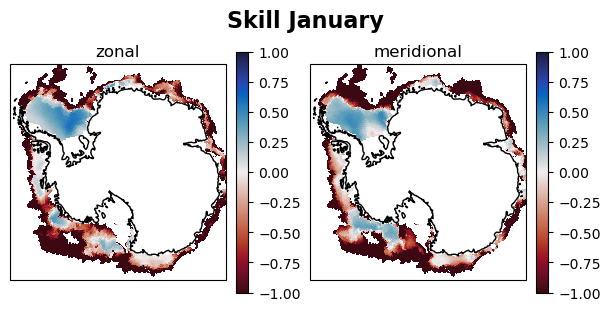

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


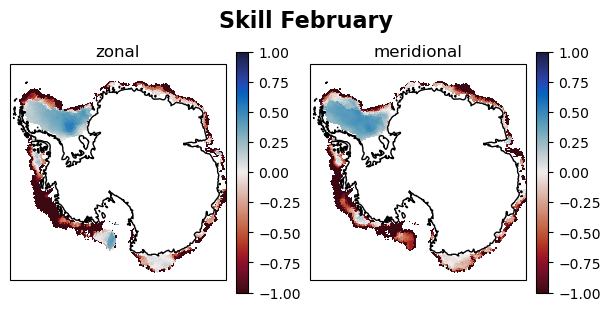

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


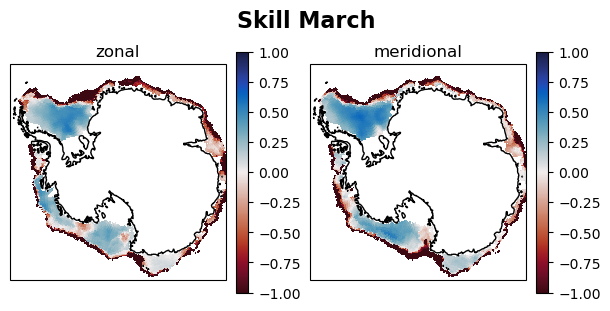

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


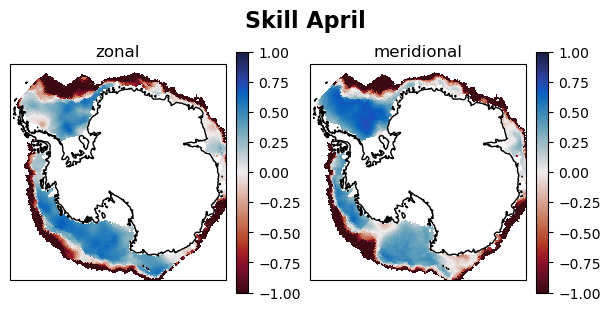

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


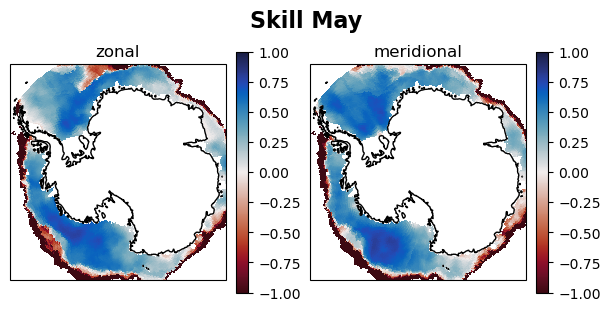

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


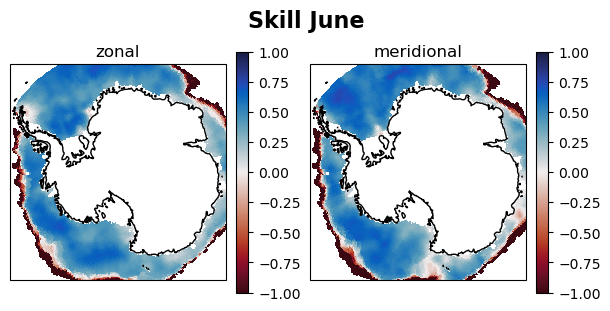

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


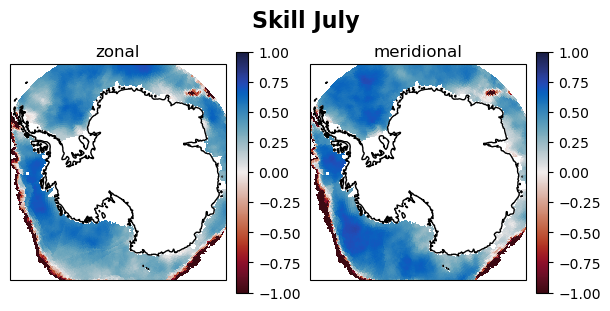

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


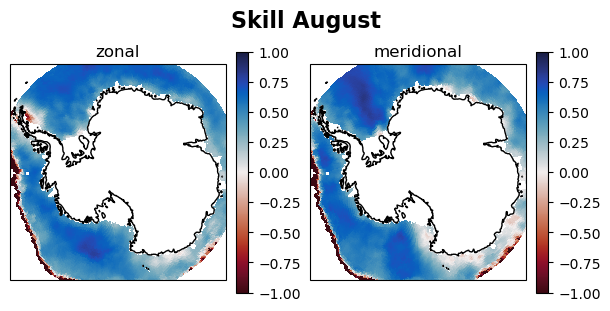

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


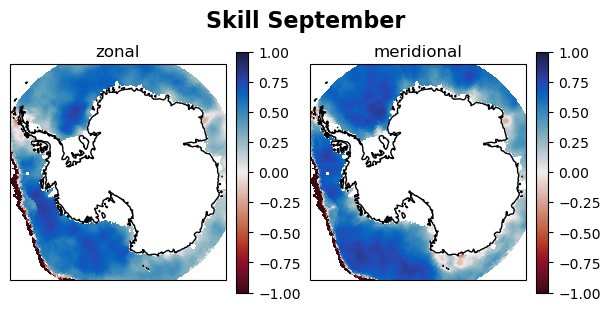

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


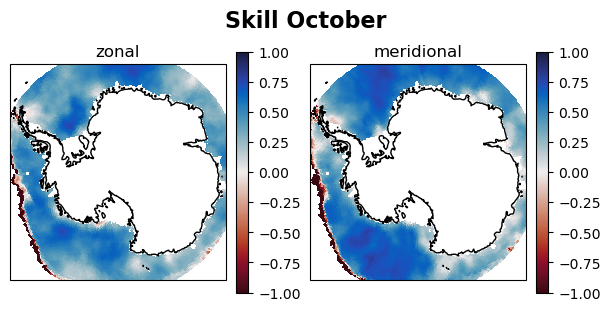

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


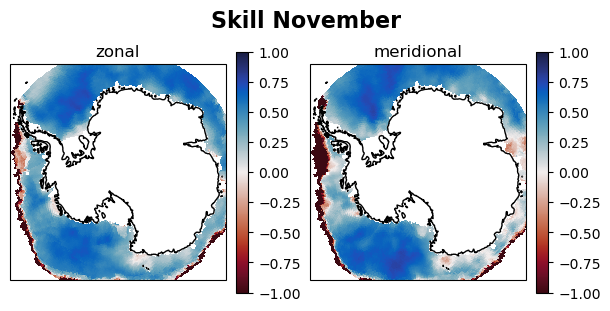

/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - mse / vartrue
/tmp/ipykernel_864801/1496635322.py:16: RuntimeWarning: invalid value encountered in divide
  skill = 1 - mse / vartrue


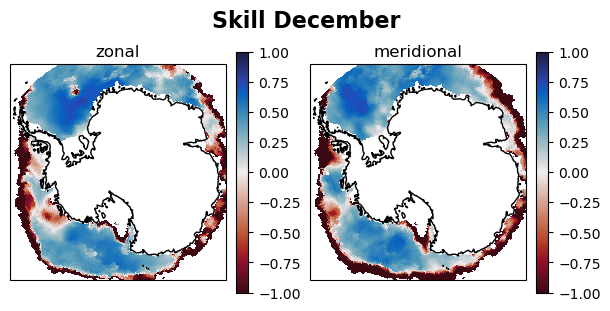

In [48]:
for i in range(0,12):

    uskill = skill(upred[months == i + 1, :,:], utrue[months == i + 1,:,:])
    vskill = skill(vpred[months == i + 1, :,:], vtrue[months == i + 1,:,:])

    uskillmonth[i,:,:] = uskill
    vskillmonth[i,:,:] = vskill

    udata = uskill
    vdata = vskill

    fig, axs = plt.subplots(
        nrows = 1,
        ncols = 2,
        figsize = (6,3),
        subplot_kw = {"projection": ccrs.SouthPolarStereo()},
        constrained_layout = True
        )

    axs[0].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
    axs[0].coastlines()
    upcm = axs[0].pcolormesh(
        lon, lat, udata, 
        transform = ccrs.PlateCarree(), 
        cmap = cmap, vmin = vmin ,vmax = vmax
    )
    axs[0].set_title("zonal")
    plt.colorbar(upcm, ax = axs[0], orientation = 'vertical')


    axs[1].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
    axs[1].coastlines()
    vpcm = axs[1].pcolormesh(
        lon, lat, vdata, 
        transform = ccrs.PlateCarree(), 
        cmap = cmap, vmin = vmin ,vmax = vmax
    )
    axs[1].set_title("meridional")
    plt.colorbar(vpcm, ax = axs[1], orientation = 'vertical')

    fig.suptitle(f"Skill {month_strings[i]}", fontsize = 16, fontweight = 'bold')

    fig.tight_layout

    plt.show()




In [ ]:
for i in range(0,12):

    udata = weighted_skill(upred[months == i + 1, :,:], utrue[months == i + 1,:,:], rtest[months == i + 1,:,:])
    vdata = weighted_skill(vpred[months == i + 1, :,:], vtrue[months == i + 1,:,:], rtest[months == i + 1,:,:])

    uweightedskillmonth[i,:,:] = udata
    vweightedskillmonth[i,:,:] = vdata

    fig, axs = plt.subplots(
        nrows = 1,
        ncols = 2,
        figsize = (6,3),
        subplot_kw = {"projection": ccrs.SouthPolarStereo()},
        constrained_layout = True
        )

    axs[0].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
    axs[0].coastlines()
    upcm = axs[0].pcolormesh(
        lon, lat, udata, 
        transform = ccrs.PlateCarree(), 
        cmap = cmap, vmin = vmin ,vmax = vmax
    )
    axs[0].set_title("zonal")
    plt.colorbar(upcm, ax = axs[0], orientation = 'vertical')


    axs[1].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
    axs[1].coastlines()
    vpcm = axs[1].pcolormesh(
        lon, lat, vdata, 
        transform = ccrs.PlateCarree(), 
        cmap = cmap, vmin = vmin ,vmax = vmax
    )
    axs[1].set_title("meridional")
    plt.colorbar(vpcm, ax = axs[1], orientation = 'vertical')

    fig.suptitle(f"Weighted Skill {month_strings[i]}", fontsize = 16, fontweight = 'bold')

    fig.tight_layout

    plt.show()

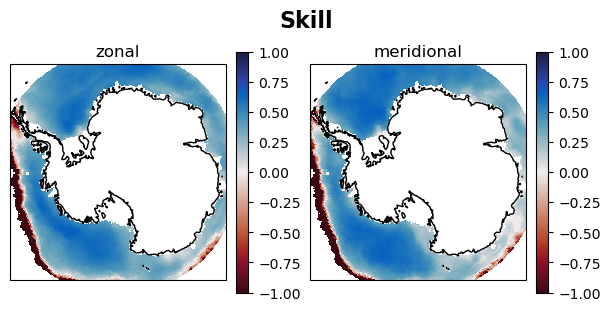

In [14]:
# NOTE include timstamp for running bash on model training and eval in the future

# set model for title
MODEL = "Weighted CNN V2"

# set latitude bounds
LAT_MIN = -90
LAT_MAX = -65

cmap = cmo.cm.balance_r
vmin = -1
vmax = 1

udata = uskill
vdata = vskill

fig, axs = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (6,3),
    subplot_kw = {"projection": ccrs.SouthPolarStereo()},
    constrained_layout = True
    )

axs[0].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
axs[0].coastlines()
upcm = axs[0].pcolormesh(
    lon, lat, udata, 
    transform = ccrs.PlateCarree(), 
    cmap = cmap, vmin = vmin ,vmax = vmax
)
axs[0].set_title("zonal")
plt.colorbar(upcm, ax = axs[0], orientation = 'vertical')


axs[1].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
axs[1].coastlines()
vpcm = axs[1].pcolormesh(
    lon, lat, vdata, 
    transform = ccrs.PlateCarree(), 
    cmap = cmap, vmin = vmin ,vmax = vmax
)
axs[1].set_title("meridional")
plt.colorbar(vpcm, ax = axs[1], orientation = 'vertical')

fig.suptitle("Skill", fontsize = 16, fontweight = 'bold')

fig.tight_layout

plt.show()


In [15]:
uweightedskill = weighted_skill(upred, utrue, rtest)
vweightedskill = weighted_skill(vpred, vtrue, rtest)

/tmp/ipykernel_841751/1286841913.py:7: RuntimeWarning: Mean of empty slice
  mse = np.nanmean(( w * (true - pred))**2, axis = 0) # mean square error
/tmp/ipykernel_841751/1286841913.py:12: RuntimeWarning: Mean of empty slice
  vartrue = np.nanmean(( w * (true - truebar))**2, axis = 0) # variance in true


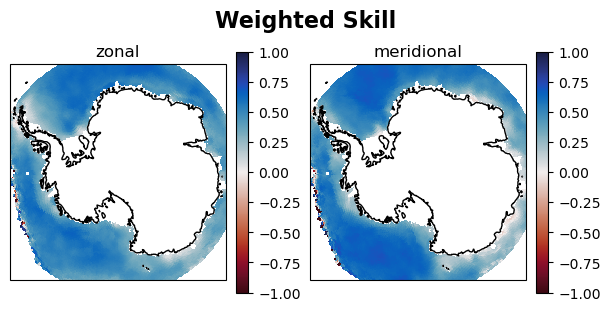

In [16]:
# NOTE include timstamp for running bash on model training and eval in the future

# set model for title
MODEL = "Weighted CNN V2"

# set latitude bounds
LAT_MIN = -90
LAT_MAX = -65

cmap = cmo.cm.balance_r
vmin = -1
vmax = 1

udata = uweightedskill
vdata = vweightedskill

fig, axs = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (6,3),
    subplot_kw = {"projection": ccrs.SouthPolarStereo()},
    constrained_layout = True
    )

axs[0].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
axs[0].coastlines()
upcm = axs[0].pcolormesh(
    lon, lat, udata, 
    transform = ccrs.PlateCarree(), 
    cmap = cmap, vmin = vmin ,vmax = vmax
)
axs[0].set_title("zonal")
plt.colorbar(upcm, ax = axs[0], orientation = 'vertical')


axs[1].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
axs[1].coastlines()
vpcm = axs[1].pcolormesh(
    lon, lat, vdata, 
    transform = ccrs.PlateCarree(), 
    cmap = cmap, vmin = vmin ,vmax = vmax
)
axs[1].set_title("meridional")
plt.colorbar(vpcm, ax = axs[1], orientation = 'vertical')

fig.suptitle("Weighted Skill", fontsize = 16, fontweight = 'bold')

fig.tight_layout

plt.show()

In [17]:
ucorrelation = correlation(upred, utrue)
vcorrelation = correlation(vpred, vtrue)

/tmp/ipykernel_841751/33829204.py:15: RuntimeWarning: invalid value encountered in divide
  correlation = covariance / (stdpred * stdtrue)


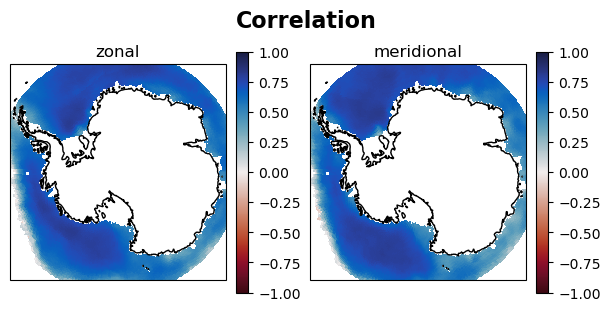

In [18]:
# set model for title
MODEL = "Weighted CNN V2"

# set latitude bounds
LAT_MIN = -90
LAT_MAX = -65

cmap = cmo.cm.balance_r
vmin = -1
vmax = 1

udata = ucorrelation
vdata = vcorrelation

fig, axs = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (6,3),
    subplot_kw = {"projection": ccrs.SouthPolarStereo()},
    constrained_layout = True
    )

axs[0].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
axs[0].coastlines()
upcm = axs[0].pcolormesh(
    lon, lat, udata, 
    transform = ccrs.PlateCarree(), 
    cmap = cmap, vmin = vmin ,vmax = vmax
)
axs[0].set_title("zonal")
plt.colorbar(upcm, ax = axs[0], orientation = 'vertical')


axs[1].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
axs[1].coastlines()
vpcm = axs[1].pcolormesh(
    lon, lat, vdata, 
    transform = ccrs.PlateCarree(), 
    cmap = cmap, vmin = vmin ,vmax = vmax
)
axs[1].set_title("meridional")
plt.colorbar(vpcm, ax = axs[1], orientation = 'vertical')

fig.suptitle("Correlation", fontsize = 16, fontweight = 'bold')

fig.tight_layout

plt.show()

In [19]:
uweightedcorrelation = weighted_correlation(upred, utrue, rtest)
vweightedcorrelation = weighted_correlation(vpred, vtrue, rtest)

/tmp/ipykernel_841751/1644685393.py:12: RuntimeWarning: invalid value encountered in divide
  return np.nansum(w * x, axis = 0) / np.nansum(w, axis = 0)
/tmp/ipykernel_841751/1644685393.py:22: RuntimeWarning: invalid value encountered in divide
  correlation = weighted_cov / (weighted_stdpred * weighted_stdtrue)


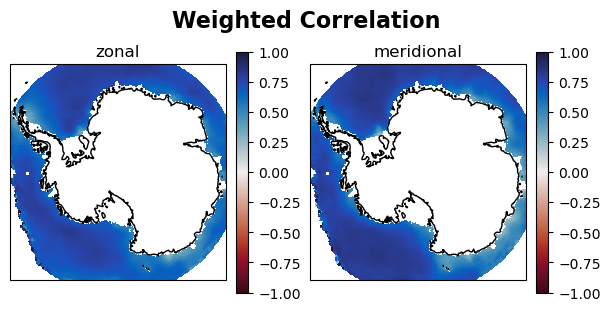

In [20]:
# set model for title
MODEL = "Weighted CNN V2"

# set latitude bounds
LAT_MIN = -90
LAT_MAX = -65

cmap = cmo.cm.balance_r
vmin = -1
vmax = 1

udata = uweightedcorrelation
vdata = vweightedcorrelation

fig, axs = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (6,3),
    subplot_kw = {"projection": ccrs.SouthPolarStereo()},
    constrained_layout = True
    )

axs[0].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
axs[0].coastlines()
upcm = axs[0].pcolormesh(
    lon, lat, udata, 
    transform = ccrs.PlateCarree(), 
    cmap = cmap, vmin = vmin ,vmax = vmax
)
axs[0].set_title("zonal")
plt.colorbar(upcm, ax = axs[0], orientation = 'vertical')


axs[1].set_extent([-180, 180, LAT_MIN, LAT_MAX], crs = ccrs.PlateCarree())
axs[1].coastlines()
vpcm = axs[1].pcolormesh(
    lon, lat, vdata, 
    transform = ccrs.PlateCarree(), 
    cmap = cmap, vmin = vmin ,vmax = vmax
)
axs[1].set_title("meridional")
plt.colorbar(vpcm, ax = axs[1], orientation = 'vertical')

fig.suptitle("Weighted Correlation", fontsize = 16, fontweight = 'bold')

fig.tight_layout

plt.show()

In [21]:
PATH = "/home/jbassham/jack/thesis-rough/data/sh/outputs/cnn/weighted"
fnam = "WCNNEval_sh_1992_2020"

PATH_DEST = os.path.join(PATH, fnam)

# Create the directory if it doesn't already exist
os.makedirs(PATH_DEST, exist_ok = True)


np.savez(
    PATH_DEST,
    uskill = uskill,
    vskill = vskill,
    uweightedskill = uweightedskill,
    vweightedskill = vweightedskill,
    ucorrelation = ucorrelation,
    vcorrelation = vcorrelation,
    uweightedcorrelation = uweightedcorrelation,
    vweightedcorrelation = vweightedcorrelation
)